Importing modules

In [731]:
import pandas as pd
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
from matplotlib import pyplot
 
series = pd.read_csv('exchange_rate.csv', index_col=0, squeeze=True)
series = pd.DataFrame(series)
series.head()

,EUR/USD Close,USD/JPY Close,USD/CHF Close,GBP/USD Close,USD/CAD Close
Date,,,,,
1/9/2017,1.05649,116.156,1.01580,1.21543,1.32276
1/10/2017,1.05582,115.743,1.01654,1.21634,1.32240
1/11/2017,1.05750,115.465,1.01498,1.22060,1.31690
1/12/2017,1.06171,114.599,1.01040,1.21621,1.31357
1/13/2017,1.06455,114.533,1.00851,1.21843,1.31225


In [780]:
eur_usd = pd.DataFrame(series['EUR/USD Close'])
usd_jpy = pd.DataFrame(series['USD/JPY Close'])
usd_chf = pd.DataFrame(series['USD/CHF Close'])
gbp_usd = pd.DataFrame(series['GBP/USD Close'])
usd_cad = pd.DataFrame(series['USD/CAD Close'])

val = usd_cad['USD/CAD Close']

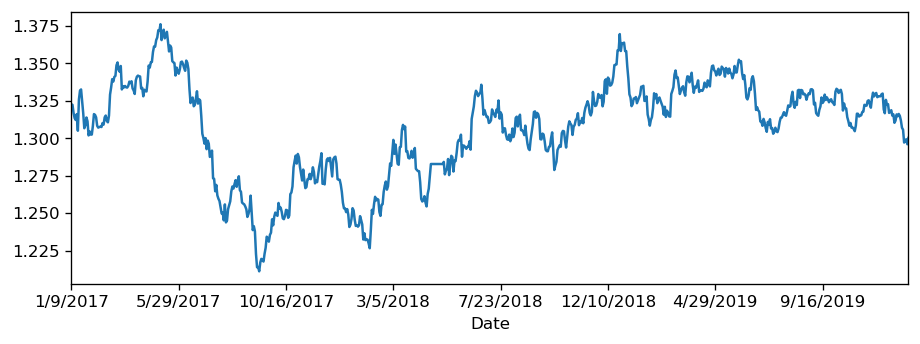

In [781]:
val.plot();

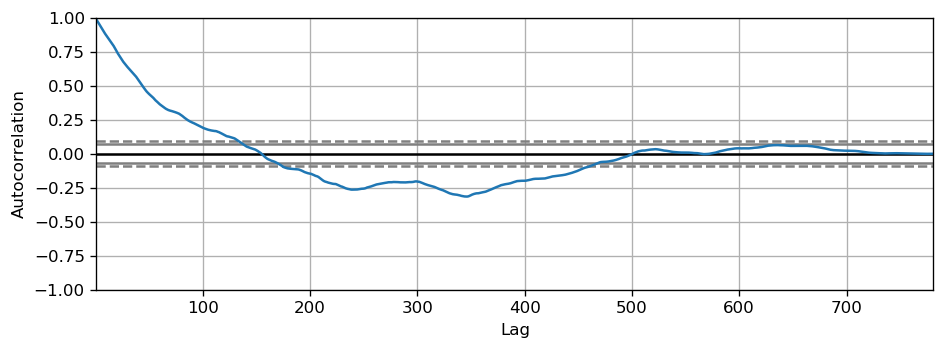

In [782]:
pd.plotting.autocorrelation_plot(val)
pyplot.show()

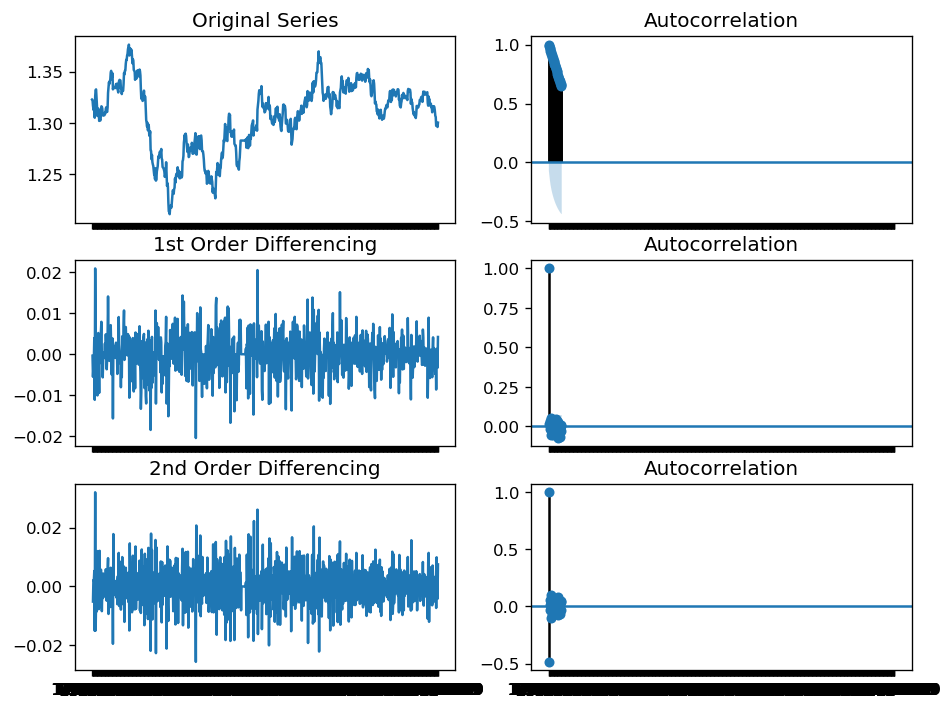

In [783]:
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(val); axes[0, 0].set_title('Original Series')
plot_acf(val, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(val.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(val.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(val.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(val.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

In [819]:
# ARIMA Model
model = ARIMA(val, order=(6,0,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                              ARMA Model Results                              
Dep. Variable:          USD/CAD Close   No. Observations:                  781
Model:                     ARMA(6, 0)   Log Likelihood                3005.145
Method:                       css-mle   S.D. of innovations              0.005
Date:                Wed, 08 Jan 2020   AIC                          -5994.290
Time:                        23:19:47   BIC                          -5957.005
Sample:                             0   HQIC                         -5979.951
                                                                              
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   1.3075      0.012    105.925      0.000       1.283       1.332
ar.L1.USD/CAD Close     1.0083      0.036     28.234      0.000       0.938       1.078
ar.L2.USD/CAD Cl

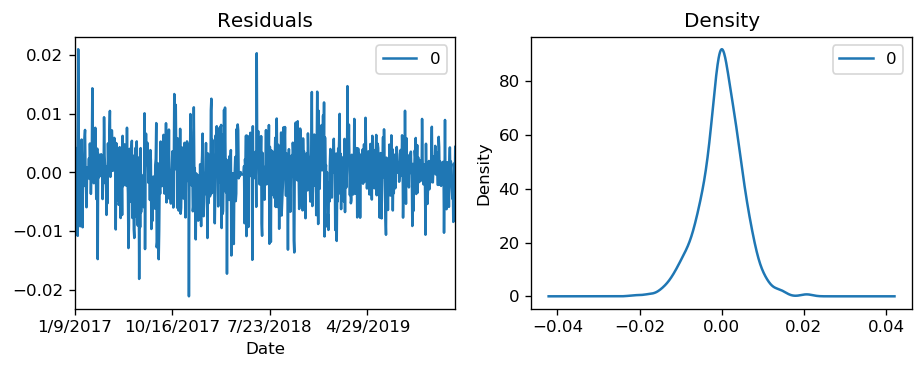

In [820]:
# Plot residual errors
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

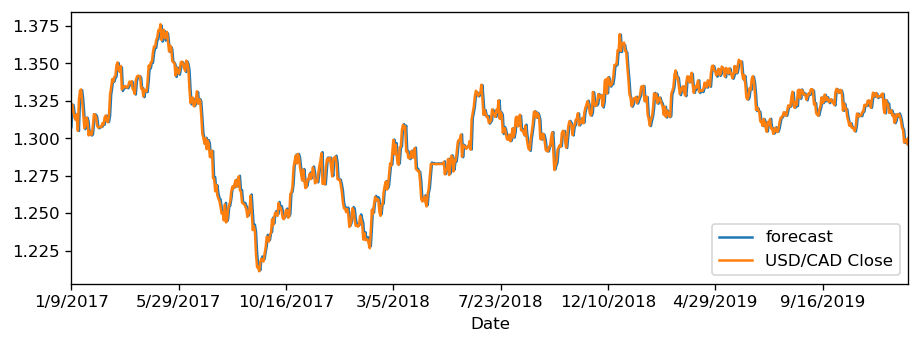

In [821]:
# Actual vs Fitted
model_fit.plot_predict(dynamic=False)
plt.show()

In [837]:
# Create Training and Test
train = (val[:750])
test = (val[750:])

In [838]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    mse = np.mean((forecast - actual)**2)       # MSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acf1 = acf(fc-test)[1]                      # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'mse':mse, 'acf1':acf1, 
            'corr':corr, 'minmax':minmax})

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  % freq, ValueWarning)


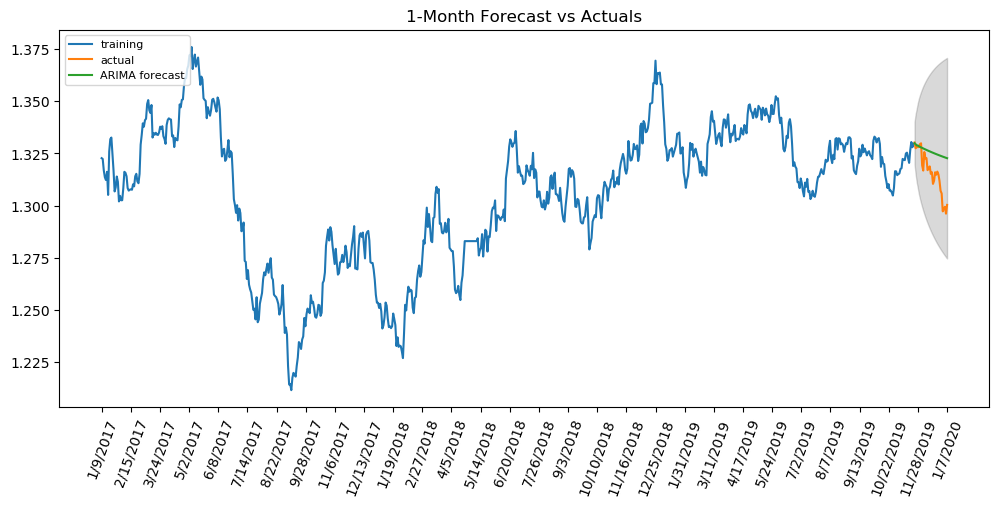

In [839]:
# Build Model
model = ARIMA(train, order=(6, 0, 0))
fitted = model.fit(disp=-1)  

# Forecast
fc, se, conf = fitted.forecast(31, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='ARIMA forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('1-Month Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.xticks(ticks = None, rotation=70)
plt.xticks(np.linspace(0, 780, 30))
plt.show()

### ARIMA model accuracy

In [840]:
forecast_accuracy(fc_series, test)
# {'mape': 0.00782422935983839,
#  'me': 0.009999345373148115,
#  'mae': 0.010234338872948294,
#  'mpe': 0.007647515039711021,
#  'rmse': 0.012980634275633835,
#  'mse': 0.00016849686619775994,
#  'acf1': 0.8323892705899272,
#  'corr': 0.9222590053610478,
#  'minmax': 0.007726726455184796}

{'mape': 0.00782422935983839,
 'me': 0.009999345373148115,
 'mae': 0.010234338872948294,
 'mpe': 0.007647515039711021,
 'rmse': 0.012980634275633835,
 'mse': 0.00016849686619775994,
 'acf1': 0.8323892705899272,
 'corr': 0.9222590053610478,
 'minmax': 0.007726726455184796}

### RANDOM WALK model

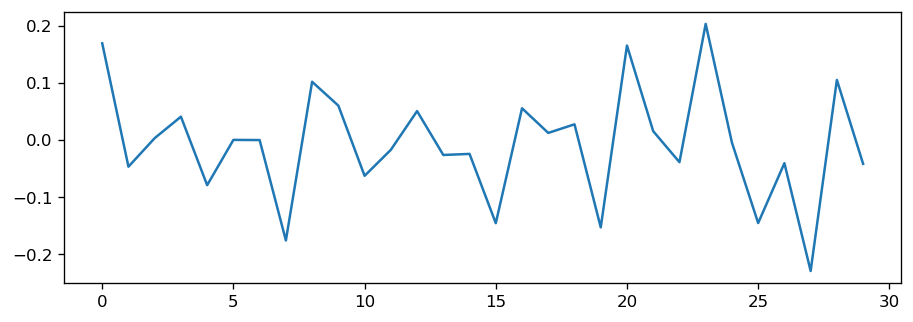

In [841]:
np.random.seed(7)
r = (np.random.randn(1, 1, 30))/10
r = r[0][0]
r = list(r)
plt.plot(r);

### Function to generate random walk series

In [842]:
def rwalk(num, rr):
    rw = [num]
    for i in rr:
        rw.append(rw[-1]+i/10)
    return list(rw)

pr = rwalk(train[-1], r);

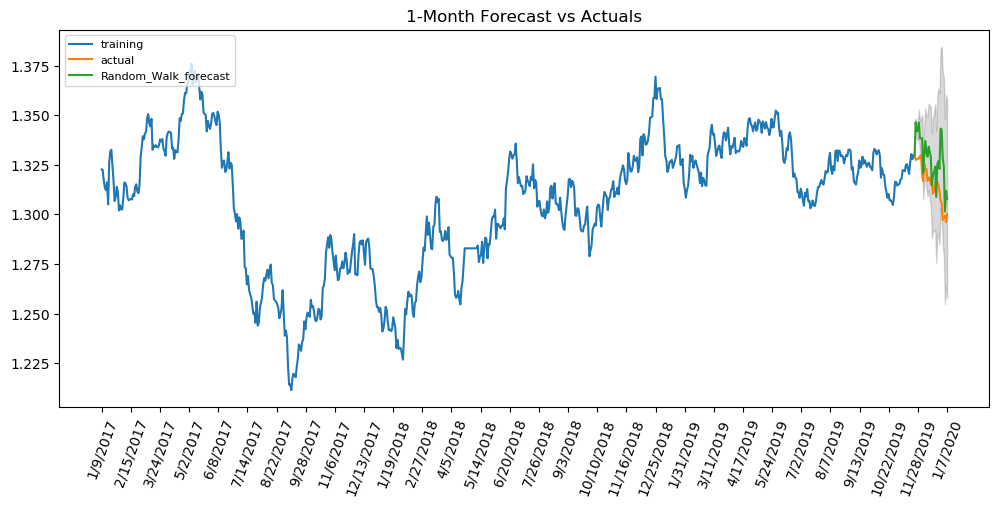

In [843]:
# # Build Model

# Make as pandas series
confed = [np.linspace(0, 0.05, 31)]

fc_series = pd.Series(pr, index=test.index)
lower_series = pd.Series(confed[0]+pr, index=test.index)
upper_series = pd.Series(-1*confed[0]+pr, index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='Random_Walk_forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('1-Month Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.xticks(ticks = None, rotation=70)
plt.xticks(np.linspace(0, 780, 30))

plt.show()

### RANDOM WALK model accuracy

In [844]:
forecast_accuracy(fc_series, test)
# {'mape': 0.010139467263306114,
#  'me': 0.0128081471256493,
#  'mae': 0.013318104943961153,
#  'mpe': 0.009752012621311108,
#  'rmse': 0.01605802700577718,
#  'mse': 0.00025786023131826923,
#  'acf1': 0.8323892705899272,
#  'corr': 0.608139204890813,
#  'minmax': 0.009992796116566782}

{'mape': 0.010139467263306114,
 'me': 0.0128081471256493,
 'mae': 0.013318104943961153,
 'mpe': 0.009752012621311108,
 'rmse': 0.01605802700577718,
 'mse': 0.00025786023131826923,
 'acf1': 0.8323892705899272,
 'corr': 0.608139204890813,
 'minmax': 0.009992796116566782}

## 6-Month Horizon Forecast

### ARIMA MODEL

In [845]:
# Create Training and Test for 6 month horizon forecast
train = (val[:600])
test = (val[600:])

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  % freq, ValueWarning)


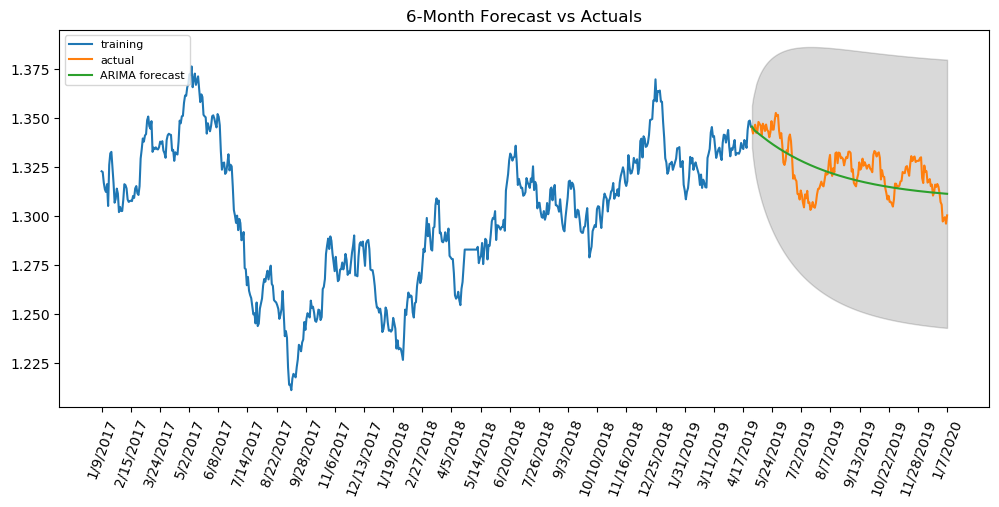

In [846]:
# Build Model
model = ARIMA(train, order=(6, 0, 0))
fitted = model.fit(disp=-1)  

# Forecast
fc, se, conf = fitted.forecast(181, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='ARIMA forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('6-Month Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.xticks(ticks = None, rotation=70)
plt.xticks(np.linspace(0, 780, 30))
plt.show()

In [847]:
forecast_accuracy(fc_series, test)
# {'mape': 0.006641974681017672,
#  'me': -0.0019700443154483734,
#  'mae': 0.008783564638315526,
#  'mpe': -0.00143705811797909,
#  'rmse': 0.010461126978164727,
#  'mse': 0.00010943517765328587,
#  'acf1': 0.9272124315406676,
#  'corr': 0.5997061705260023,
#  'minmax': 0.006613028118813813}

{'mape': 0.006641974681017672,
 'me': -0.0019700443154483734,
 'mae': 0.008783564638315526,
 'mpe': -0.00143705811797909,
 'rmse': 0.010461126978164727,
 'mse': 0.00010943517765328587,
 'acf1': 0.9272124315406676,
 'corr': 0.5997061705260023,
 'minmax': 0.006613028118813813}

### RANDOM WALK model

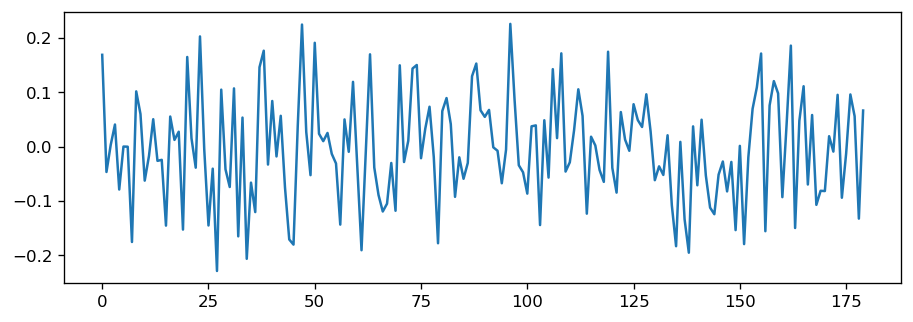

In [848]:
np.random.seed(7)
r = (np.random.randn(1, 1, 180))/10
r = r[0][0]
r = list(r)
plt.plot(r);

In [849]:
pr = rwalk(train[-1], r);

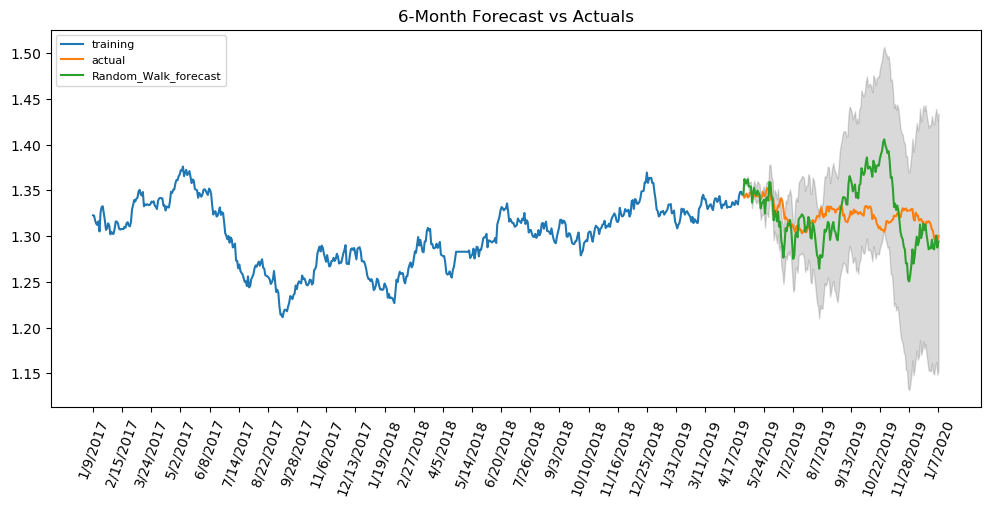

In [851]:
# # Build Model
# model = ARIMA(train, order=(11, 1, 0))
# fitted = model.fit(disp=-1)  

# # Forecast
# fc, se, conf = fitted.forecast(31, alpha=0.05)  # 95% conf

# Make as pandas series
confed = [np.linspace(0, 0.14, 181)]

fc_series = pd.Series(pr, index=test.index)
lower_series = pd.Series(confed[0]+pr, index=test.index)
upper_series = pd.Series(-1*confed[0]+pr, index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='Random_Walk_forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('6-Month Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.xticks(ticks = None, rotation=70)
plt.xticks(np.linspace(0, 780, 30))

plt.show()

In [852]:
forecast_accuracy(fc_series, test)
# {'mape': 0.020222739538090746,
#  'me': 0.0017194528520314187,
#  'mae': 0.0267344076771006,
#  'mpe': 0.001350469134805299,
#  'rmse': 0.03512225518684805,
#  'mse': 0.0012335728094100748,
#  'acf1': 0.9272124315406676,
#  'corr': 0.1589885316428043,
#  'minmax': 0.01980449620430169}

{'mape': 0.020222739538090746,
 'me': 0.0017194528520314187,
 'mae': 0.0267344076771006,
 'mpe': 0.001350469134805299,
 'rmse': 0.03512225518684805,
 'mse': 0.0012335728094100748,
 'acf1': 0.9272124315406676,
 'corr': 0.1589885316428043,
 'minmax': 0.01980449620430169}